拍謝頗雜亂
by pochun

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/irtm.csv')  
count_row = df.shape[0] 
count_col = df.shape[1]
print(count_row)
print(count_col)
print(df.columns)
print(df['object_class'].unique())

5739
5
Index(['title', 'object_class', 'content', 'rating', 'url'], dtype='object')
['euclid' 'thaumiel' 'keter' 'safe' 'neutralized']


In [3]:
print("Max rating \n" , df.loc[df['rating'].idxmax()] , "\n")
print("Min rating \n" , df.loc[df['rating'].idxmin()])

Max rating 
 title                                                     SCP-173
object_class                                               euclid
content         SCP-173 in containment\n SCP-173\n Euclid\n It...
rating                                                       6541
url                           http://scp-wiki.wikidot.com/scp-173
Name: 4354, dtype: object 

Min rating 
 title                                                 SCP-138-ARC
object_class                                               euclid
content          SCP-138\n Euclid\n \n \n SCP-138 appears to b...
rating                                                        -59
url                       http://scp-wiki.wikidot.com/scp-138-arc
Name: 5023, dtype: object


AxesSubplot(0.125,0.125;0.775x0.755)


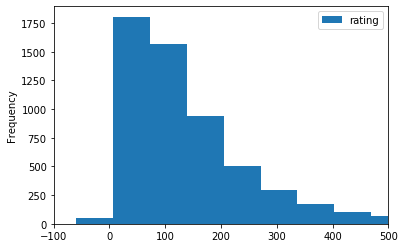

In [4]:
print(df.plot.hist(bins = 100 , xlim = (-100 , 500)))

In [5]:
print(df.groupby('object_class').count())

              title  content  rating   url
object_class                              
euclid         2368     2367    2368  2368
keter          1024     1024    1024  1024
neutralized     231      231     231   231
safe           1987     1984    1987  1987
thaumiel        129      129     129   129


In [6]:
l = [i for i in range(count_row)]
df['index'] = l

training validation testing 的切法還須調整

In [91]:
train_df = df.iloc[4500 : count_row] 
val_df = df.iloc[3000 : 4000]
test_df = df.iloc[0 : 1000]
train_df = train_df.reset_index()
val_df = val_df.reset_index()
test_df = test_df.reset_index()
train_df = train_df.drop(columns = ['level_0'])
val_df = val_df.drop(columns = ['level_0'])
test_df = test_df.drop(columns = ['level_0'])

In [92]:
class_test_df = test_df.groupby("object_class")
euclid_test_df = class_test_df.get_group("euclid")
thaumiel_test_df = class_test_df.get_group("thaumiel")
keter_test_df = class_test_df.get_group("keter")
safe_test_df = class_test_df.get_group("safe")
# 照此切法 testing 沒有 neutralized QQ
# neutralized_test_df = class_test_df.get_group("neutralized")

In [93]:
class_train_df = train_df.groupby("object_class")
euclid_train_df = class_train_df.get_group("euclid")
thaumiel_train_df = class_train_df.get_group("thaumiel")
keter_train_df = class_train_df.get_group("keter")
safe_train_df = class_train_df.get_group("safe")
neutralized_train_df = class_train_df.get_group("neutralized")

In [94]:
e_index_list_train = euclid_train_df['index'].tolist()
t_index_list_train = thaumiel_train_df['index'].tolist()
k_index_list_train = keter_train_df['index'].tolist()
s_index_list_train = safe_train_df['index'].tolist()
n_index_list_train = neutralized_train_df['index'].tolist()

以下是我的 PA3 經過些微調整

In [65]:
import glob
import os
import math

In [11]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def term_extraction (txt):
    txt = str(txt) 
    punctuation = ["\n" , "``" , '$' , ', ' , '. ' , '; ' , '.' , '_' , ':' , "''" , '\"' , '\'' , '\"' , '(' , ')', '!' , '?' , '‘' , '*' , '&' , '`' , '\\']
    for mark in punctuation:
        txt = txt.replace(mark , ' ')
    txt = txt.replace(',' , '')
    txt = txt.replace("\'s " , " is ")
    txt = txt.replace("-" , " ")
    split_txt = []
    temp = ''
    for char in txt:
        if char == ' ':
            split_txt.append(temp)
            temp = ''
        else:
            temp += char
    if temp:
        split_txt.append(temp)
    token = []
    for s in split_txt:
        token.append(s.lower())
    ps_token = []
    for word in token:
        ps_token.append(ps.stem(word))
    stop_word = ["", "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
    final = []
    for word in ps_token:
        appear = False
        for stop in stop_word:
            if word == stop:
                appear = True
        if not appear and word.isalpha():
            final.append(word)

    return final

In [12]:
def to_dictionary (vocabulary_collection) :
    dictionary = pd.DataFrame(columns = ['term' , 'df' , 'cf'])
    df = 0
    cf = 0
    for d in vocabulary_collection:
        for t in d:
            if t not in dictionary.values:        
                for d2 in vocabulary_collection :
                    cf = cf + d2.count(t)
                    if t in d2:
                        df = df + 1
                dictionary.loc[-1] = [t , df , cf]  
                dictionary.index = dictionary.index + 1
            df = 0
            cf = 0
    dictionary.sort_values(by = ['term'] , inplace = True , ascending = True)
    dictionary = dictionary.reset_index(drop = True)
    dictionary.to_csv('pochun_testing/dictionary.txt' , index = None , sep = ' ')

In [13]:
def to_class_dictionary (train_df , dictionary) :
    class_df = []
    for i in range (5) :
        if (i == 0) :
            cdocument_list = e_index_list_train
        elif (i == 1) :
            cdocument_list = t_index_list_train
        elif (i == 2) :
            cdocument_list = k_index_list_train
        elif (i == 3) :
            cdocument_list = s_index_list_train
        elif (i == 4) :
            cdocument_list = n_index_list_train
        else :
            print("wrong_class_index")

        class_collection = ''
        for docId in cdocument_list :     
            class_df_index = train_df[train_df['index'] == docId].index.tolist()
            index = class_df_index[0]
            string = train_df.iloc[index]['content']  
            class_collection = class_collection + string
        class_vocabulary = term_extraction(class_collection)
        c = pd.DataFrame(columns = ['term' , 'classf'])
        for t in dictionary['term'] :
            classf = class_vocabulary.count(t)
            c.loc[-1] = [t , classf]
            c.index = c.index + 1    
        class_df.append(c)
    for c in class_df :
        prob = []
        for index , row in c.iterrows() :        
            prob.append(math.log((row['classf'] + 1) / (c['classf'].sum() + 500)))
        c['probability'] = prob
    return class_df

In [67]:
def to_class_vocabulary (train_df) :
    class_vocabulary = [] 
    
    for i in range(5):
        class_vocabulary.append([])

    for i in range (5) :
        if (i == 0) :
            cdocument_list = e_index_list_train
        elif (i == 1) :
            cdocument_list = t_index_list_train
        elif (i == 2) :
            cdocument_list = k_index_list_train
        elif (i == 3) :
            cdocument_list = s_index_list_train
        elif (i == 4) :
            cdocument_list = n_index_list_train
        else :
            print("wrong_class_index")
        
        for docId in cdocument_list :
#             print(docId)
            class_df_index = train_df[train_df['index'] == docId].index.tolist()
#             print(class_df_index)
            index = class_df_index[0]
            string = train_df.iloc[index]['content'] 
            class_vocabulary[i].append(term_extraction(string)) 
    return class_vocabulary

In [15]:
def to_test_df (test_vocabulary_collection , dictionary) :
    test_df = []
    for d in test_vocabulary_collection :
        tdoc = pd.DataFrame(columns = ['term' , 'tf'])
        for t in d :
            tf = 0
            if (t in dictionary.values) and (t not in tdoc.values) :
                tf = d.count(t)
                tdoc.loc[-1] = [t , tf]
                tdoc.index = tdoc.index + 1    
        test_df.append(tdoc)
    return test_df

In [75]:
# os.mkdir("pochun_testing")
all_list = []
for i in range(count_row) :
    all_list.append(str(i))
train_list = [i for i in range(4500 , count_row)]
val_list = [i for i in range(3000 , 4000)]
test_list = [i for i in range(0 , 1000)]

In [17]:
collection = []
for docId in train_list : 
    class_df_index = df[df['index'] == docId].index.tolist()
    index = class_df_index[0]
    string = df.iloc[index]['content'] 
    collection.append(string)
vocabulary_collection = []
for i in range(len(collection)):
    vocabulary_collection.append(term_extraction(collection[i]))
to_dictionary(vocabulary_collection)

In [68]:
dictionary = pd.read_csv('pochun_testing/dictionary.txt' , sep = " ")
zeros = [0] * len(dictionary)
dictionary['chi'] = zeros
class_vocabulary = to_class_vocabulary(train_df)
chi_table = []

for term_index in range(len(dictionary)) :
    chi_n_2 = pd.DataFrame()
    zeros13 = [-1] * 13
    chi_n_2['present'] = zeros13
    chi_n_2['absent'] = zeros13
    term = dictionary.iloc[term_index]['term']
    for class_index in range(len(class_vocabulary)) :
        present = 0
        for class_doc_index in range(len(class_vocabulary[class_index])) :
            
            if term in class_vocabulary[class_index][class_doc_index] :
                present = present + 1
        chi_n_2['present'][class_index] = present
        absent = 15 - present
        chi_n_2['absent'][class_index] = absent
    chi_score = 0
    for index , row in chi_n_2.iterrows() :
        expect = (15 / (13 * 15)) * (chi_n_2['present'].sum() / (13 * 15)) * (13 * 15)
        n = row['present']
        chi_score = chi_score + ((n - expect)**2 / expect)
        expect = (15 / (13 * 15)) * (chi_n_2['absent'].sum() / (13 * 15)) * (13 * 15)
        n = row['absent']
        chi_score = chi_score + ((n - expect)**2 / expect)
    dictionary['chi'][term_index] = chi_score
dictionary = dictionary.sort_values(by = ['chi'] , ascending = False)
dictionary = dictionary.sort_values(by = ['chi'] , ascending = False)
dictionary = dictionary.reset_index(drop = True)
dictionary = dictionary.head(500)

C:\Users\pochunwu\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\pochunwu\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\pochunwu\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\pochunwu\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\pochunwu\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWa

chi square == inf 應該有錯誤QQ(暫時查無原因QQ)

In [69]:
print(dictionary)

          term  df  cf         chi
0     restrain  39  50         inf
1      nostril   3   3         inf
2        press  14  17         inf
3    hemispher   1   1         inf
4        tumbl   2   5         inf
..         ...  ..  ..         ...
495   facsimil   1   1  489.689655
496        fee   2   2  489.689655
497    vocalis   3   3  489.689655
498  physician   4   5  489.689655
499    patienc   7   7  489.689655

[500 rows x 4 columns]


In [71]:
class_df = to_class_dictionary(train_df , dictionary)
for i in range(len(class_df)) :
    class_df[i] = class_df[i].reset_index(drop = True)

In [72]:
print(class_df)

[          term classf  probability
0     restrain     40    -4.832986
1      nostril      2    -7.447946
2        press     15    -5.773969
3    hemispher      4    -6.937120
4        tumbl      1    -7.853411
..         ...    ...          ...
495   facsimil      1    -7.853411
496        fee      3    -7.160263
497    vocalis      1    -7.853411
498  physician      1    -7.853411
499    patienc      1    -7.853411

[500 rows x 3 columns],           term classf  probability
0     restrain      4    -6.582025
1      nostril      1    -7.498316
2        press     26    -4.895626
3    hemispher      5    -6.399704
4        tumbl      1    -7.498316
..         ...    ...          ...
495   facsimil      2    -7.092851
496        fee      3    -6.805169
497    vocalis      3    -6.805169
498  physician      4    -6.582025
499    patienc      2    -7.092851

[500 rows x 3 columns],           term classf  probability
0     restrain     19    -5.480431
1      nostril      3    -7.089868
2   

In [95]:
test_collection = []
for docId in test_list:        
    class_df_index = test_df[test_df['index'] == docId].index.tolist()
    index = class_df_index[0]
    string = test_df.iloc[index]['content'] 
    test_collection.append(string)
test_vocabulary_collection = []
for i in range(len(test_collection)):
    test_vocabulary_collection.append(term_extraction(test_collection[i]))
test_dff = to_test_df(test_vocabulary_collection , dictionary)
for i in range(len(test_df)) :
    test_dff[i] = test_dff[i].reset_index(drop = True)

In [96]:
answer = []
for d in test_dff :
    class_index = 0
    clist = []
    for c in class_df :
        if class_index == 0 :
            p = math.log(2368 / (2368 + 1024 + 231 + 1987 + 129))
        elif class_index == 1 :
            p = math.log(1024 / (2368 + 1024 + 231 + 1987 + 129))
        elif class_index == 2 :
            p = math.log(231 / (2368 + 1024 + 231 + 1987 + 129))
        elif class_index == 3 :
            p = math.log(1987 / (2368 + 1024 + 231 + 1987 + 129))
        elif class_index == 4 :
            p = math.log(129 / (2368 + 1024 + 231 + 1987 + 129))
        else :
            print("wrong class index")
        class_index = class_index + 1
        for index , row in d.iterrows() :
            t = row['term']
            if (t in c.values) and (t in dictionary.values) :
                class_df_index = c[c['term'] == t].index.tolist()
                index = class_df_index[0]
#                 print(index)
                prob = c.iloc[index]['probability']
#                 print(prob)
                p = p + prob * row['tf']
        clist.append(p)  
    maxi = -99999999
    maxIndex = -1
    for i in range(len(clist)):
        if clist[i] > maxi:
            maxi = clist[i]
            maxIndex = i + 1
    answer.append(maxIndex)
print(answer)
answer = [x - 1 for x in answer]
index = list(map(int , test_list))
output = pd.DataFrame(list(zip(test_list , answer)) , columns =['Id', 'Value'])
output.to_csv('pochun_testing/result.csv' , index = None , sep = ',')     

[3, 2, 5, 5, 1, 5, 5, 2, 2, 5, 4, 3, 4, 1, 4, 5, 4, 4, 2, 3, 4, 2, 4, 5, 2, 5, 1, 3, 1, 3, 1, 3, 3, 3, 4, 3, 1, 1, 2, 2, 5, 1, 5, 3, 3, 4, 1, 3, 5, 5, 3, 3, 1, 5, 3, 4, 3, 4, 1, 5, 5, 1, 5, 4, 1, 3, 5, 2, 5, 4, 5, 5, 2, 1, 5, 2, 2, 2, 4, 3, 5, 1, 1, 1, 4, 1, 2, 1, 1, 4, 2, 1, 3, 5, 2, 2, 1, 4, 1, 3, 1, 5, 4, 2, 4, 3, 5, 2, 4, 1, 3, 4, 1, 3, 1, 4, 3, 1, 1, 2, 3, 2, 1, 1, 1, 1, 5, 3, 4, 5, 4, 1, 4, 2, 4, 1, 4, 4, 4, 5, 1, 3, 4, 2, 5, 1, 4, 4, 2, 1, 3, 1, 2, 1, 2, 1, 1, 3, 2, 1, 3, 1, 1, 5, 4, 2, 5, 1, 1, 1, 1, 4, 1, 3, 3, 1, 1, 4, 3, 2, 5, 1, 4, 1, 1, 1, 1, 1, 1, 3, 4, 5, 5, 5, 4, 1, 4, 4, 3, 1, 4, 1, 2, 1, 1, 5, 4, 4, 4, 4, 1, 1, 4, 1, 3, 1, 1, 4, 5, 3, 1, 4, 3, 1, 4, 4, 3, 2, 1, 4, 1, 1, 5, 1, 3, 2, 5, 5, 1, 5, 1, 3, 1, 3, 3, 5, 1, 4, 1, 1, 1, 5, 2, 3, 1, 5, 4, 2, 5, 1, 3, 1, 3, 4, 3, 4, 2, 4, 2, 4, 1, 4, 2, 4, 1, 1, 3, 1, 4, 1, 1, 4, 4, 1, 3, 4, 5, 4, 2, 4, 4, 1, 1, 1, 4, 4, 3, 1, 4, 4, 1, 4, 5, 5, 3, 1, 1, 2, 2, 1, 5, 2, 2, 5, 2, 2, 2, 4, 4, 3, 3, 3, 3, 5, 1, 5, 1, 1, 1, 1, 5, 1, 1, 

0 - 4 分別代表 'euclid' 'thaumiel' 'keter' 'safe' 'neutralized'
以上印出來的結果應該全部 -1(輸出的csv有減))

In [97]:
count = 1
for c in class_df :
    c.to_csv('pochun_testi有檢/class' + str(count) + '.txt' , index = None , sep = ' ')
    count  = count + 1

In [98]:
count = 1
for t in test_dff :
    t.to_csv('pochun_testing/test' + str(count) + '.txt' , index = None , sep = ' ')
    count  = count + 1

In [99]:
dictionary.to_csv('pochun_testing/dic500' + str(count) + '.txt' , index = None , sep = ' ')

In [103]:
test_df['object_class'] = test_df['object_class'].replace("euclid", 0)
test_df['object_class'] = test_df['object_class'].replace("thaumiel", 1)
test_df['object_class'] = test_df['object_class'].replace("keter", 2)
test_df['object_class'] = test_df['object_class'].replace("safe", 3)
test_df['object_class'] = test_df['object_class'].replace("neutralized", 4)


In [104]:
count = 0
for i in range(1000) :
    if(test_df.at[i , 'object_class'] == answer[i]) :
        count = count + 1
print(count)

270


In [106]:
test_df.to_csv('pochun_testing/test_df.csv' , index = None , sep = ',')